In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import copy
import tarfile
import requests
import re
import sys
import warnings
warnings.filterwarnings('ignore')
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.font_manager as font_manager
import cv2
import pandas as pd
import pickle
from numpy.linalg import norm

In [11]:
# load data
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data
      
def getLayerIndexByName(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx

#check acc and asr
def calculate_acc(model,x_train,y_train):
  if x_train.shape[0] % 10 ==0: 
    n_split=10
  else:
    n_split = 9 
  x_train=np.array(np.split(x_train,n_split))
  y_pred = []

  for i in range(len(x_train)):
    x_train[i] = tf.convert_to_tensor(x_train[i])
    y_pred.append(np.argmax(model(x_train[i]).numpy(), axis=1))
  y_pred=np.array(y_pred).flatten()
  return np.mean(np.equal(y_pred, y_train)) * 100            

def get_norm(weights,ord):
  norm = []
  for i in range( weights.shape[3]):
    norm.append(tf.norm(weights[:,:,:,i],ord=ord).numpy())
  return np.array(norm),np.argsort(np.array(norm)),np.mean(np.array(norm))



In [12]:
!wget https://github.com/vbabushkin/ECE_GY_9163_Machine_Learning_for_Cyber_Security_Project/raw/main/models/sunglasses_bd_net.h5
!wget https://github.com/vbabushkin/ECE_GY_9163_Machine_Learning_for_Cyber_Security_Project/raw/main/models/sunglasses_bd_weights.h5

--2022-05-02 17:03:39--  https://github.com/vbabushkin/ECE_GY_9163_Machine_Learning_for_Cyber_Security_Project/raw/main/models/sunglasses_bd_net.h5
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vbabushkin/ECE_GY_9163_Machine_Learning_for_Cyber_Security_Project/main/models/sunglasses_bd_net.h5 [following]
--2022-05-02 17:03:40--  https://raw.githubusercontent.com/vbabushkin/ECE_GY_9163_Machine_Learning_for_Cyber_Security_Project/main/models/sunglasses_bd_net.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7274924 (6.9M) [application/octet-stream]
Saving to: ‘sunglasses_bd_net.h5.1’

sunglass

In [13]:
data_path="/content/drive/MyDrive/fine-pruning/data/Lab3"

clean_data_valid_filename = data_path+"/cl/valid.h5"
clean_data_test_filename = data_path+"/cl/test.h5"

bd_valid_filename = data_path+"/bd/bd_valid.h5"
bd_test_filename = data_path+"/bd/bd_test.h5"


# model_path="/content/drive/MyDrive/fine-pruning/models"
# b_model_path  = model_path+"/bd_net.h5"
# b_weights_path = model_path+"/bd_weights.h5"

# bprime_model_path = model_path+"/bd_net_tmp.h5"
# bprime_weights_path = model_path+"/bd_weights_tmp.h5"


In [14]:
b_model_path = "/content/sunglasses_bd_net.h5"
b_weights_path = "/content/sunglasses_bd_weights.h5"

bprime_model_path = "/content/clean_net.h5"
bprime_weights_path = "/content/clean_weights.h5"


In [15]:
lr = 1e-3
epochs = 10
batch_size = 32
tf.random.set_seed(42)
np.random.seed(42)

In [16]:
def finePruning(conv_layer_idx,B_path,B_weights_path,B_prime_path, B_prime_weights_path, lr, epochs, batch_size, percentChRemovedThreshold, clean_data_valid_filename,clean_data_test_filename,poisoned_data_test_filename =None,prune_method="l1norm",verbose=False):
  if prune_method not in {'l1norm', 'l2norm', 'apoz'}:
    raise ValueError('Invalid `pruning method`')

    # define optimizer
  opt = tf.keras.optimizers.Adam(learning_rate=lr)
    # load baseline model
  B = keras.models.load_model(B_path)
  B.load_weights(B_weights_path)
    
    # define the B_prime model and initialize it with the same weights as B (initally it is the same as the baseline)
  B_prime = keras.models.load_model(B_path)
  B_prime.load_weights(B_weights_path)
    
   
  cl_x_valid, cl_y_valid = data_loader(clean_data_valid_filename)
  cl_x_test, cl_y_test = data_loader(clean_data_test_filename)
  bd_x_test, bd_y_test = data_loader(poisoned_data_test_filename)
    

  clean_accuracy_valid_orig = calculate_acc(B_prime,cl_x_valid,cl_y_valid)
  clean_accuracy_test_orig = calculate_acc(B_prime,cl_x_test,cl_y_test)
  asr_test_orig = calculate_acc(B_prime,bd_x_test,bd_y_test)

  print("Clean validation accuracy before modification: {0:3.6f}".format(clean_accuracy_valid_orig))
  print("Clean test accuracy before modification: {0:3.6f}".format(clean_accuracy_test_orig))
  print("Attack success rate before modification: {0:3.6f}".format(asr_test_orig))
    
  convLayerWeights = B.layers[conv_layer_idx].get_weights()[0]
  convLayerBiases  = B.layers[conv_layer_idx].get_weights()[1]

  if prune_method == "l1norm":

      # get the activations and sort them in an increasing order excluding empty layers
      norms,sorted_idx_list,threshold_value = get_norm(convLayerWeights,ord = 1)
  elif prune_method == "l2norm":
      norms,sorted_idx_list,threshold_value = get_norm(convLayerWeights,ord = "euclidean")

  # elif prune_method == "apoz":
  #     layer=B_prime.layers[conv_layer_idx]
  #     norms = identify.get_apoz(B_prime, layer, bd_x_test)
  #     allIdxToPrune = np.argsort(norms)
  #     idxToPrune = identify.high_apoz(norms,method="both")

  res_shape = convLayerWeights.shape[3] + 1

  totalIters=np.zeros((res_shape))  
  totalIdx=np.zeros((res_shape))
  totalPercentChannelsRemoved = np.zeros((res_shape))
  totalCleanAccuracyValid = np.zeros((res_shape))
  totalAttackSuccessRateValid = np.zeros((res_shape))
  totalCleanAccuracyTest = np.zeros((res_shape))
  totalAttackSuccessRateTest = np.zeros((res_shape))
  percentValidationAccuracy = []

  iter = 0
    # before the fine pruning estimate the baseline clean validation/test accuracies:
  percentChannelsRemoved = 0 # no channel has been removed yet
  totalIters[iter] = iter
  totalIdx[iter]=0
  totalPercentChannelsRemoved[iter] = percentChannelsRemoved
  totalCleanAccuracyValid[iter] = clean_accuracy_valid_orig
  totalCleanAccuracyTest[iter] = clean_accuracy_test_orig
  totalAttackSuccessRateTest[iter] = asr_test_orig
  iter+=1

  for idx in sorted_idx_list:
    percentChannelsRemoved = iter / convLayerWeights.shape[3]
    if norms[idx] < threshold_value:
      if verbose == True:
        print("pruning idx : ",idx)
      #set weight and bias value of idx to zero
      convLayerWeights[:,:,:,idx] = 0
      convLayerBiases[idx] =  0
      B_prime.layers[conv_layer_idx].set_weights([convLayerWeights,convLayerBiases])

      #train model in updated weights 
      B_prime.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])
      # B_prime.fit(cl_x_test, cl_y_test, epochs=epochs, batch_size=batch_size,verbose=verbose)
      B_prime.fit(cl_x_valid, cl_y_valid, epochs=epochs, batch_size=batch_size,verbose=False)
      tf.keras.backend.clear_session()

      #evaluate model on clean validation data, clean test data and attack success rate
      clean_accuracy_valid =  calculate_acc(B_prime,cl_x_valid,cl_y_valid)
      clean_accuracy_test = calculate_acc(B_prime,cl_x_test,cl_y_test)
      asr_test = calculate_acc(B_prime,bd_x_test,bd_y_test)
      if verbose == True:
        print("Iteration = {0:3d}, channel removed = {1:3d}, percent channels removed = {2:3.6f}\nClean validation accuracy after modification: {3:3.6f}\n Clean test accuracy after modification: {4:3.6f}, attack success rate test =  {5:3.6f}".format(
                    iter, idx, percentChannelsRemoved * 100, clean_accuracy_valid, clean_accuracy_test, asr_test))
      #save metrics
      totalIdx[iter]=idx
      totalPercentChannelsRemoved[iter] = percentChannelsRemoved
      totalCleanAccuracyValid[iter] = clean_accuracy_valid
      totalCleanAccuracyTest[iter] = clean_accuracy_test
      totalAttackSuccessRateTest[iter] = asr_test
      totalIters[iter] = iter
      iter = iter + 1

    else: # element not pruned
      if verbose == True:
        
        print("Iteration = {0:3d}\nClean validation accuracy after modification: {1:3.6f}\n Clean test accuracy after modification: {2:3.6f}, attack success rate test =  {3:3.6f}".format(
                    iter, clean_accuracy_valid, clean_accuracy_test, asr_test))
      
      # B_prime.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])
      # # B_prime.fit(cl_x_test, cl_y_test, epochs=epochs, batch_size=batch_size,verbose=verbose)
      # B_prime.fit(cl_x_valid, cl_y_valid, epochs=epochs, batch_size=batch_size,verbose=False)
      # tf.keras.backend.clear_session()
      totalIdx[iter]=idx
      totalPercentChannelsRemoved[iter] = percentChannelsRemoved
      totalCleanAccuracyValid[iter] = clean_accuracy_valid
      totalCleanAccuracyTest[iter] = clean_accuracy_test
      totalAttackSuccessRateTest[iter] = asr_test
      totalIters[iter] = iter
      iter = iter + 1
      
    
  B_prime.save(B_prime_path)
  B_prime.save_weights(B_prime_weights_path)
  return (totalIdx,totalIters,totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest)


GLOBAL PRUNING THRESHOLD VALUE L2 NORM : 1.1840869 L1 NORM : 15.160831
AFTER CONV 1 PRUNED : 
Clean validation accuracy before modification: 0.077942
Clean test accuracy before modification: 0.077942
Attack success rate before modification: 0.000000


In [17]:

conv_layer_idx = 5

prune_method = "l1norm"
(totalIdx,totalIters,totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest) = finePruning(conv_layer_idx,b_model_path,b_weights_path,
                                                                                                                    bprime_model_path,bprime_weights_path,
                                                                                                                    lr, epochs, batch_size, 100, 
                                                                                                                    clean_data_valid_filename,clean_data_test_filename, 
                                                                                                                    bd_test_filename,
                                                                                                                    prune_method=prune_method,
                                                                                                                    verbose=True)


df = pd.DataFrame({'totalIdx':totalIdx,'totalIters':totalIters,'totalPercentChannelsRemoved':totalPercentChannelsRemoved,'totalCleanAccuracyValid':totalCleanAccuracyValid,'totalCleanAccuracyTest':totalCleanAccuracyTest,'totalAttackSuccessRateTest':totalAttackSuccessRateTest})
df.to_csv("/content/results-"+prune_method+"-convlayer-"+str(conv_layer_idx)+".csv", index=False)

Clean validation accuracy before modification: 42.253399
Clean test accuracy before modification: 42.361652
Attack success rate before modification: 99.929852
pruning idx :  49
Iteration =   1, channel removed =  49, percent channels removed = 1.666667
Clean validation accuracy after modification: 96.362692
 Clean test accuracy after modification: 84.988309, attack success rate test =  47.396726
pruning idx :  34
Iteration =   2, channel removed =  34, percent channels removed = 3.333333
Clean validation accuracy after modification: 95.635230
 Clean test accuracy after modification: 82.073266, attack success rate test =  8.293063
pruning idx :  44
Iteration =   3, channel removed =  44, percent channels removed = 5.000000
Clean validation accuracy after modification: 98.285269
 Clean test accuracy after modification: 85.487140, attack success rate test =  5.159782
pruning idx :  32
Iteration =   4, channel removed =  32, percent channels removed = 6.666667
Clean validation accuracy aft

In [ ]:
conv_layer_idx = 3

prune_method = "l1norm"
(totalIters,totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest) = finePruning(conv_layer_idx,b_model_path,b_weights_path,
                                                                                                                    b_model_path,b_weights_path,
                                                                                                                    lr, epochs, batch_size, 100, 
                                                                                                                    clean_data_valid_filename,clean_data_test_filename, 
                                                                                                                    bd_test_filename,
                                                                                                                    prune_method=prune_method,
                                                                                                                    verbose=True)


df = pd.DataFrame({'totalIters':totalIters,'totalPercentChannelsRemoved':totalPercentChannelsRemoved,'totalCleanAccuracyValid':totalCleanAccuracyValid,'totalCleanAccuracyTest':totalCleanAccuracyTest,'totalAttackSuccessRateTest':totalAttackSuccessRateTest})
df.to_csv("/content/results-"+prune_method+"-convlayer-"+str(conv_layer_idx)+".csv", index=False)

KeyboardInterrupt: ignored

In [ ]:
conv_layer_idx = 5

prune_method = "l1norm"
(totalIters,totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest) = finePruning(conv_layer_idx,b_model_path,b_weights_path,
                                                                                                                    b_model_path,b_weights_path,
                                                                                                                    lr, epochs, batch_size, 100, 
                                                                                                                    clean_data_valid_filename,clean_data_test_filename, 
                                                                                                                    bd_test_filename,
                                                                                                                    prune_method=prune_method,
                                                                                                                    verbose=True)


df = pd.DataFrame({'totalIters':totalIters,'totalPercentChannelsRemoved':totalPercentChannelsRemoved,'totalCleanAccuracyValid':totalCleanAccuracyValid,'totalCleanAccuracyTest':totalCleanAccuracyTest,'totalAttackSuccessRateTest':totalAttackSuccessRateTest})
df.to_csv("/content/results-"+prune_method+"-convlayer-"+str(conv_layer_idx)+".csv", index=False)

Clean validation accuracy before modification: 99.411102
Clean test accuracy before modification: 79.945440
Attack success rate before modification: 0.000000
pruning idx :  41
Iteration =   1, channel removed =  41, percent channels removed = 1.666667
Clean validation accuracy after modification: 99.878756
 Clean test accuracy after modification: 81.652377, attack success rate test =  0.015588
pruning idx :  50
Iteration =   2, channel removed =  50, percent channels removed = 3.333333
Clean validation accuracy after modification: 99.878756
 Clean test accuracy after modification: 81.987529, attack success rate test =  0.000000
pruning idx :  31
Iteration =   3, channel removed =  31, percent channels removed = 5.000000
Clean validation accuracy after modification: 99.333160
 Clean test accuracy after modification: 79.501169, attack success rate test =  0.000000
pruning idx :  0
Iteration =   4, channel removed =   0, percent channels removed = 6.666667
Clean validation accuracy after 

In [ ]:
import pandas as pd
df = pd.read_csv("/content/results-l2norm-convlayer-5.csv")


totalPercentChannelsRemoved = df['totalPercentChannelsRemoved'].to_numpy()

totalCleanAccuracyTest = df['totalCleanAccuracyTest'].to_numpy()

totalCleanAccuracyValid = df['totalCleanAccuracyValid'].to_numpy()

totalAttackSuccessRateTest = df['totalAttackSuccessRateTest'].to_numpy()



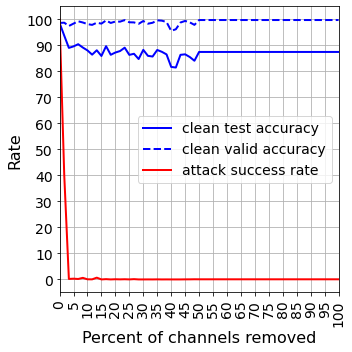

In [ ]:
fig, axs = plt.subplots(figsize=(5, 5))
xticks = [str("%.0f" % (x * 100)) for x in totalPercentChannelsRemoved]
xticks = np.asarray(xticks)[list(range(0, 61,3))]
axs.set_yticks(np.arange(0, 101, 10))
axs.set_xticks(np.arange(0, 1.001, 0.05))
axs.set_xticklabels(xticks, rotation=90)
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
axs.set_ylabel('Rate', fontsize=16)
axs.set_xlabel('Percent of channels removed', fontsize=16)
axs.set_xlim([0, 1])
axs.plot(totalPercentChannelsRemoved, totalCleanAccuracyTest, color = 'b',linestyle = 'solid', linewidth=2,label="clean test accuracy")
axs.plot(totalPercentChannelsRemoved, totalCleanAccuracyValid, color = 'b',linestyle = 'dashed', linewidth=2, label='clean valid accuracy')
axs.plot(totalPercentChannelsRemoved, totalAttackSuccessRateTest, 'r-', linewidth=2, label='attack success rate')

# axs.set_title("Accuracy on the clean test data set and attack success rate on the backdoored \n test data",fontsize=10)
font = font_manager.FontProperties(size=14)
axs.legend(loc='best', prop=font)
plt.grid()
fig.tight_layout()